# Titanic with Machine Learning Pocket Reference and other sources to get a great score ;)
by Matt Harrison

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import ensemble, preprocessing, tree
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from yellowbrick.model_selection import LearningCurve

### Get the data

In [2]:
url = 'http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls'
df = pd.read_excel(url)
dr_clean = df

### Clean the data
Check for:
1. Data types
2. Missing data
3. Outliers (seeing min and max values using pandas describe function)
4. Leaky data. In this example body column (Body Identification Number) leaks data that the person did not survive.
5. Cardinality 
6. Multicollinearity; can impact interpretation of feature importance and coefficients in some models, e.g. sex_male and sex_female columns are perfectly inverse correlated.

In [3]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [4]:
df.shape

(1309, 14)

In [5]:
df.describe().iloc[:,:2]

,pclass,survived
count,1309.000000,1309.000000
mean,2.294882,0.381971
std,0.837836,0.486055
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,3.000000,1.000000
max,3.000000,1.000000


In [6]:
df.isnull().mean()

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.200917
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000764
cabin        0.774637
embarked     0.001528
boat         0.628724
body         0.907563
home.dest    0.430863
dtype: float64

In [7]:
df = df.drop(columns=['home.dest', 'boat', 'body', 'cabin', 'ticket', 'name'])

In [8]:
df = pd.get_dummies(df)

In [9]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [10]:
df = df.drop(columns='sex_male')

In [11]:
y = df.survived
X = df.drop(columns='survived')

### Visualisation 
To show trends in the data for understanding and later imputation

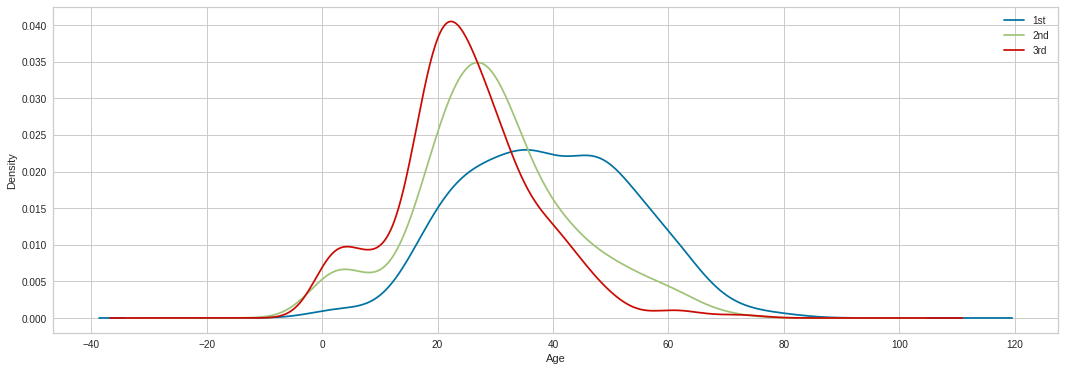

In [12]:
fig = plt.figure(figsize=(18,6))
for x in [1,2,3]:
    df.age[df.pclass == x].plot(kind='kde')
plt.legend(('1st', '2nd', '3rd'))
plt.xlabel('Age')
plt.show()

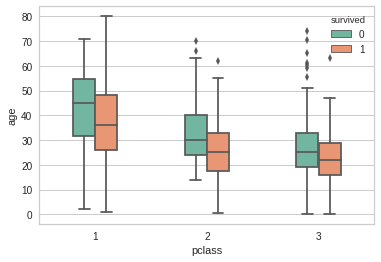

In [13]:
sns.boxplot(x='pclass', y='age', hue='survived', width=0.4, data=df, palette='Set2');

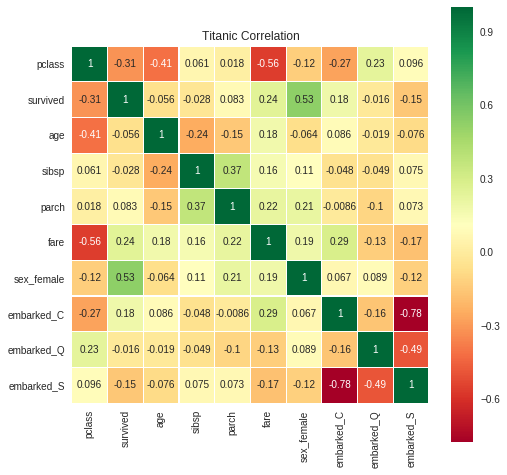

In [14]:
corr = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, vmax=1, square=True, cmap='RdYlGn', linewidths=0.1, annot=True)
plt.title('Titanic Correlation');

### Sample Data 
How well will the model generalise. Do this first before I impute missing values so not to leak values (cheating by giving future information to the model).

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Impute Data

In [16]:
X_train.isnull().sum()

pclass          0
age           197
sibsp           0
parch           0
fare            1
sex_female      0
embarked_C      0
embarked_Q      0
embarked_S      0
dtype: int64

In [17]:
X_test.isnull().sum()

pclass         0
age           66
sibsp          0
parch          0
fare           0
sex_female     0
embarked_C     0
embarked_Q     0
embarked_S     0
dtype: int64

##### Age
Fill the missing age data with the median age based on the gender and class of an observation.

In [18]:
def fill_missing_age_values(data):
    grouped = data.groupby(['sex_female', 'pclass'])
    print(grouped.age.median())
    data.age = grouped.age.apply(lambda x: x.fillna(x.median()))

In [19]:
fill_missing_age_values(X_train)

sex_female  pclass
0           1         40.0
            2         29.0
            3         24.0
1           1         35.0
            2         28.0
            3         22.0
Name: age, dtype: float64


/home/rachel/miniconda3/envs/100-days-of-code/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [20]:
fill_missing_age_values(X_test)

sex_female  pclass
0           1         47.0
            2         30.5
            3         26.0
1           1         39.0
            2         24.0
            3         22.0
Name: age, dtype: float64


##### Fare

In [21]:
def fill_missing_fare_values(data):
    grouped = data.groupby(['pclass'])
    print(grouped.fare.median())
    data.fare = grouped.fare.apply(lambda x: x.fillna(x.median()))

In [22]:
fill_missing_fare_values(X_train)

pclass
1    59.400
2    17.375
3     8.050
Name: fare, dtype: float64


### Normalize Data
Normalizing or pre-processing the data will help many models perform better after this is done. Particularly those that depend on a distance metric to determine similarity. (Note that tree models, which treat each feature on its own don’t have this requirement).

Standardizing is translating the data so that it has a mean value of zero and a standard deviation of one. This way models don’t treat variables with larger scales as more important that than smaller scaled variables.

In [23]:
X_train.dtypes

pclass          int64
age           float64
sibsp           int64
parch           int64
fare          float64
sex_female      uint8
embarked_C      uint8
embarked_Q      uint8
embarked_S      uint8
dtype: object

In [24]:
X_train.head()

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
1139,3,38.0,0,0,7.8958,0,0,0,1
678,3,6.0,1,1,15.2458,0,1,0,0
290,1,52.0,1,1,79.6500,0,0,0,1
285,1,67.0,1,0,221.7792,0,0,0,1
1157,3,18.0,1,1,20.2125,0,0,0,1


In [25]:
cols = 'pclass, age, sibsp, parch., fare, sex_female, embarked_C, embarked_Q, embarked_S'.split(',')
ss = preprocessing.StandardScaler()

In [26]:
X_train = ss.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=cols)

In [27]:
X_train.head()

,pclass,age,sibsp,parch.,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,0.836547,0.718386,-0.498313,-0.433006,-0.491287,-0.74146,-0.501274,-0.32745,0.652589
1,0.836547,-1.749122,0.439969,0.673189,-0.351135,-0.74146,1.994917,-0.32745,-1.532359
2,-1.549072,1.797921,0.439969,0.673189,0.876947,-0.74146,-0.501274,-0.32745,0.652589
3,-1.549072,2.954566,0.439969,-0.433006,3.587116,-0.74146,-0.501274,-0.32745,0.652589
4,0.836547,-0.823806,0.439969,0.673189,-0.256428,-0.74146,-0.501274,-0.32745,0.652589
